# Dataset background information

Telco customer churn dataset:

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

## Data-dictionary

Each row represents a customer, each column contains customer’s attributes.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


# Objective of analysis

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."  The benefit of this analysis will be keeping the old customers renewing program to increase the customer lifetime value (CLV).

So in our modelling, we have to locate & approach the churned customers before they perform churning action. 

For the modelling details, we will use deep learning models with different hyperparameter to classify the customers.

This dataset is detailed in:
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [4]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
# %pip3 install tensorflow

## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [6]:
# import files & check out the details

data = pd.read_csv('Telco_Customer_Churn.csv')
print(data.shape)
print(data.head())
print(data.dtypes)

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

# Table of contents for analysis

In this analysis, we will first conduct 

    1. Feature engineeering
    2. Pre-processing
    3. StratifiedShuffle train-test-Spli
    4. Get a baseline performance using Random Forest
    5. Build a Single Hidden Layer Neural Network
    6. Support vector machine
    7. model evaluation & insights

## Feature engineering

### change datatype of "TotalCharges" from object to float

In [7]:
# change datatype of "TotalCharges" from object to float

# find the missing values - by null
print(data.TotalCharges.isnull().sum())

# find the missing values - by empty string
print(data.TotalCharges.str.isspace().sum())

0
11


In [8]:
# trim the empty string
data.TotalCharges = data.TotalCharges.str.strip()

# change datatype
data['TotalCharges'] = pd.to_numeric(data.TotalCharges)

### checking for missing values

In [9]:
# find the missing values - by null
print(data.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [10]:
# remove rorws with missing values
data = data.dropna().reset_index(drop=True)

### dropping meaningless column (e.g. customerID)

In [11]:
# for object features, filtering for meaningful variables (remove column with unique values e.g. customerID)
data.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [12]:
# drop customerID before one-hot encoding
data = data.drop(['customerID'], axis=1)

### 1/0 transformation for target variable -- Churn

In [13]:
# change from yes/no to 1/0 for target column
data['Churn'] = data.Churn.apply(lambda x: 1 if x == 'Yes' else 0)

In [14]:
data['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

### One-hot encoding for categorical variables:

In [15]:
# showing datatypes summary of all columns
data.dtypes.value_counts()

object     15
int64       3
float64     2
dtype: int64

There are 16 categorical features which potentially needs one-hot encoding. 

In [16]:
# getting list of object column
obj_col_list = data.dtypes[data.dtypes == np.object].index.tolist() 

In [17]:
# one hot encoding
data_oh = pd.get_dummies(data, columns = obj_col_list ,drop_first=True)
print(data_oh.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0            0   
1              0      34           56.95       1889.50      0            1   
2              0       2           53.85        108.15      1            1   
3              0      45           42.30       1840.75      0            1   
4              0       2           70.70        151.65      1            0   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            1               0                 0   
1            0               0                 1   
2            0               0                 1   
3            0               0                 0   
4            0               0                 1   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                               1  ...                                0   
1                               0  ...                              

## Pre-processing

For column not in 1/0 (i.e.  'tenure','MonthlyCharges','TotalCharges' ) , we conduct min-max scaling for these.

In [26]:
# features columns
cols_without_target =  ['Churn'] 
cols_with_target = ['Churn']

# exclude column1, column2, ...
feature_df = data_oh.loc[:, ~data_oh.columns.isin(cols_without_target)]
target_df = data_oh.loc[:, data_oh.columns.isin(cols_with_target)]

In [27]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

for column in ['tenure','MonthlyCharges','TotalCharges' ]:
    feature_df[column] = mm.fit_transform(feature_df[[column]])

KNN & SVM are highly deviated by imbalanced dataset. We have to resample the dataset, making our target variable clalss in 50-50 ratio to have better evaluation

## StratifiedShuffle train-test-Split

In [28]:
## performing train-test split
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(feature_df, target_df))

# Create the dataframes
X_train = feature_df.loc[train_idx, :]
y_train = target_df.loc[train_idx]

X_test  = feature_df.loc[test_idx, :]
y_test  = target_df.loc[test_idx]

In [29]:
### resampling to have the balanced dataset -- Churn: not churn = 50:50  from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [30]:
print('y_train_value_ratio:', y_train.value_counts(normalize=True) , '\n')
print('y_test_value_ratio:', y_test.value_counts(normalize=True) , '\n')

y_train_value_ratio: Churn
0        0.5
1        0.5
dtype: float64 

y_test_value_ratio: Churn
0        0.734123
1        0.265877
dtype: float64 



## Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [31]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [32]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.769
roc-auc is 0.814


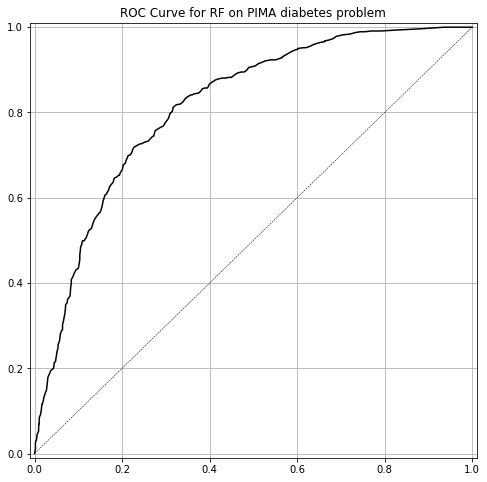

In [33]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 30 variables, so we set the input shape to 30.  Let's start by having a single hidden layer with 12 nodes.

In [34]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [35]:
# Define the Model 
# Input size is 30-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (30,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [36]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                372       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
226/226 [==============================] - 2s 5ms/step - loss: 0.6608 - accuracy: 0.5982 - val_loss: 0.6945 - val_accuracy: 0.4919
Epoch 2/200
226/226 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6608 - val_loss: 0.6532 - val_accuracy: 0.6588
Epoch 3/200
226/226 [==============================] - 1s 5ms/step - loss: 0.6133 - accuracy: 0.7298 - val_loss: 0.6272 - val_accuracy: 0.7085
Epoch 4/200
226/226 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7460 - val_loss: 0.6096 - val_accuracy: 0.7152
Epoch 5/200
226/226 [==============================] - 1s 5ms/step - loss: 0.5840 - accuracy: 0.7518 - val_loss: 0.5964 - val_accuracy: 0.7161
Epoch 6/200
226/226 [==============================] - 1s 5ms/step - loss: 0.5724 - accuracy: 0.7568 - val_loss: 0.5858 - val_accuracy: 0.7166
Epoch 7/200
226/226 [==============================] - 1s 5ms/step - loss: 0.5624 - accuracy: 0.7608 - val_loss: 0.5776 - val_accuracy: 0.7199

In [38]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32")

y_pred_prob_nn_1 = model_1.predict(X_test_norm)

66/66 [==============================] - 0s 2ms/step


In [39]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [40]:
y_pred_prob_nn_1[:10]

array([[0.3567536 ],
       [0.6405168 ],
       [0.0815747 ],
       [0.08999131],
       [0.08092818],
       [0.39340782],
       [0.5448318 ],
       [0.30865255],
       [0.07647114],
       [0.07840337]], dtype=float32)

accuracy is 0.745
roc-auc is 0.828


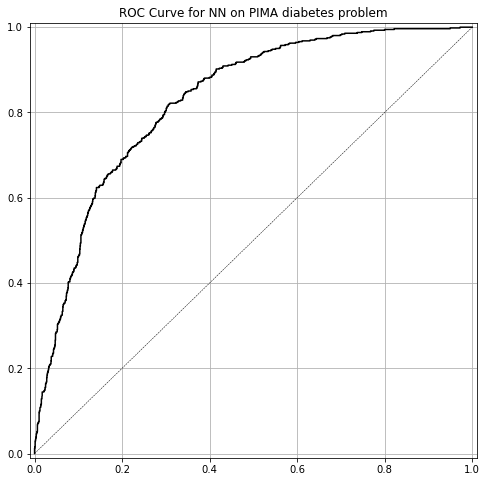

In [41]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [42]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

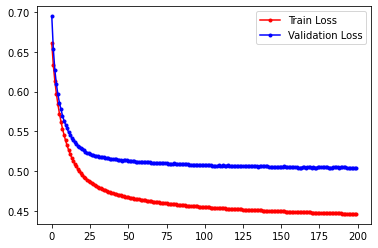

In [43]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [44]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
226/226 [==============================] - 1s 3ms/step - loss: 0.4465 - accuracy: 0.7916 - val_loss: 0.5044 - val_accuracy: 0.7445
Epoch 2/1000
226/226 [==============================] - 1s 3ms/step - loss: 0.4465 - accuracy: 0.7915 - val_loss: 0.5043 - val_accuracy: 0.7450
Epoch 3/1000
226/226 [==============================] - 1s 4ms/step - loss: 0.4464 - accuracy: 0.7915 - val_loss: 0.5044 - val_accuracy: 0.7450
Epoch 4/1000
226/226 [==============================] - 1s 4ms/step - loss: 0.4464 - accuracy: 0.7919 - val_loss: 0.5044 - val_accuracy: 0.7450
Epoch 5/1000
226/226 [==============================] - 1s 4ms/step - loss: 0.4463 - accuracy: 0.7918 - val_loss: 0.5045 - val_accuracy: 0.7450
Epoch 6/1000
226/226 [==============================] - 1s 3ms/step - loss: 0.4462 - accuracy: 0.7921 - val_loss: 0.5045 - val_accuracy: 0.7450
Epoch 7/1000
226/226 [==============================] - 1s 3ms/step - loss: 0.4462 - accuracy: 0.7914 - val_loss: 0.5045 - val_accuracy:

66/66 [==============================] - 0s 1ms/step

accuracy is 0.751
roc-auc is 0.830


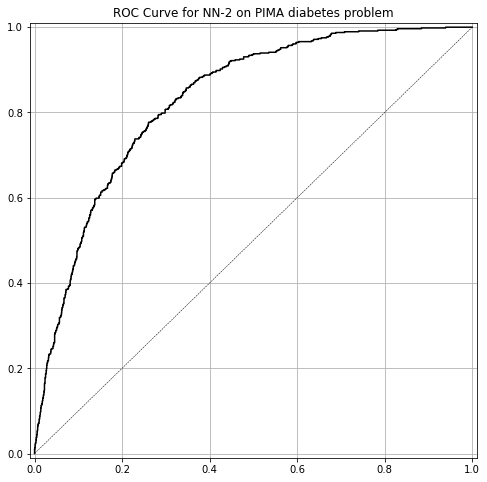

In [45]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32")

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN-2')
### END SOLUTION

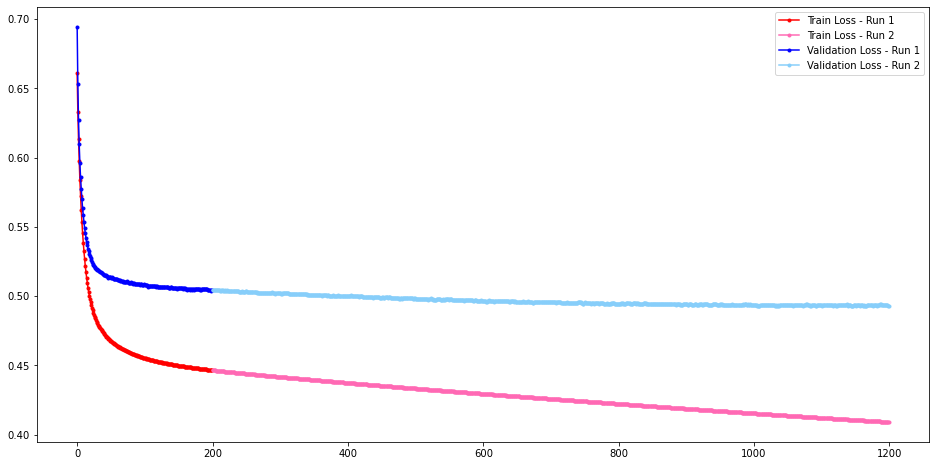

In [46]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss is NOT going down.

## Build 2 Hidden Layers Neural Network
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [47]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(30,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
226/226 [==============================] - 1s 2ms/step - loss: 0.7525 - accuracy: 0.5361 - val_loss: 0.7175 - val_accuracy: 0.5834
Epoch 2/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6393 - val_loss: 0.6184 - val_accuracy: 0.6507
Epoch 3/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6862 - val_loss: 0.5728 - val_accuracy: 0.6739
Epoch 4/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.5673 - accuracy: 0.7165 - val_loss: 0.5499 - val_accuracy: 0.6820
Epoch 5/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.5459 - accuracy: 0.7351 - val_loss: 0.5376 - val_accuracy: 0.6872
Epoch 6/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.7476 - val_loss: 0.5305 - val_accuracy: 0.6905
Epoch 7/1500
226/226 [==============================] - 0s 2ms/step - loss: 0.5160 - accuracy: 0.7543 - val_loss: 0.5271 - val_accuracy:

In [48]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

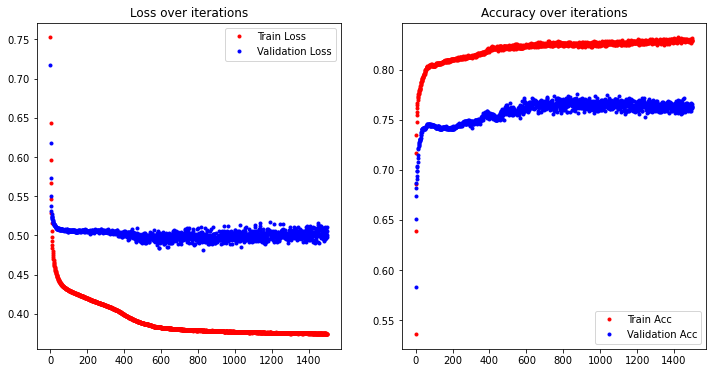

In [49]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

66/66 [==============================] - 0s 2ms/step

accuracy is 0.762
roc-auc is 0.822


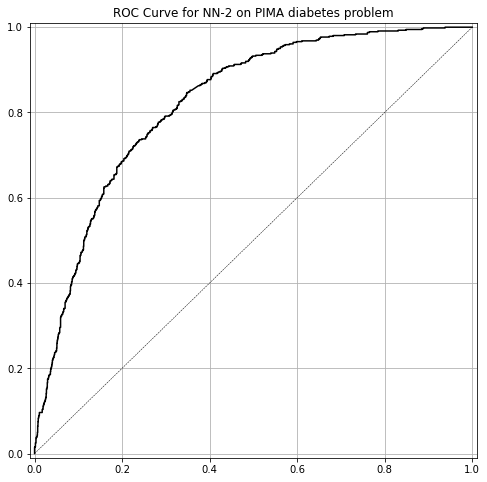

In [50]:
y_pred_class_nn_2 = (model_2.predict(X_test_norm) > 0.5).astype("int32")

y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

The accuracy increased a bit and AUC decreased a bit. Generally the performance is similar to 1 layer NN with 1000 epochs.

## model evaluation & insights

To recap the evaluation metrics:

Random Forest:
- accuracy is 0.769
- roc-auc is 0.814

Deep learning model (Single Hidden Layer Neural Network, epochs = 200):
- accuracy is 0.745
- roc-auc is 0.828

Deep learning model (Single Hidden Layer Neural Network, epochs = 1000):
- accuracy is 0.751
- roc-auc is 0.830

Deep learning model (two hidden layers, each with 6 nodes, epochs = 1500):
- accuracy is 0.762
- roc-auc is 0.822

Compared among NN models, the accuracy increased with more complex model, while the AUC performs similarly. 

# Suggested-action for extra-mile

To further improves the model, generally for NN models, We can try adding more hidden layer with more nodes and different activation function with grid search. After trying more combination, we will find the optized hyperparameteres e.g. epochs, number of nodes in different hidden layers, different activation in different nodes.


For above NN model case, compared to Random forest model, Random forest model are more generalized as they randomly select features & sub-sampling for each tree. NN models perform worse may be due to overfitting so we can apply regularization in further experimentation.

Appendix:  (NN models speciality)

For epochs tuning:
The deep learning model improves with adding more epochs when the validation error still going down. And the models starts not improving, when the validation error stabilzes. 

For model complexility tuning:
Adding 1 more hidden layer & setting ReLU activation instead of sigmoid in the hidden layer, which not only between [0,1] , so that increase the variance. 